In [2]:

import os, sys
sys.path.append(os.path.join('/home1/user/ken-takeda/COLOR/scripts/', '../'))

import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset

from src.color_embedding_MDS import MakeDataset, MainTraining, KFoldCV
from src.utils.utils import get_reorder_idxs


# fix all random seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(0)
torch.set_num_threads(1)
os.environ['OMP_NUM_THREADS'] = '1'

In [3]:
### Set parameters
data = "neutyp" # "neutyp" or "atyp"

if data == "neutyp":
    N_participant = 426
    data_dir = "../data/color_neurotypical/numpy_data/"
elif data == "atyp":
    N_participant = 257
    data_dir = "../data/color_atypical/numpy_data/"


# sample participants
Z = 128
# sample
participants_list = random.sample(range(N_participant), Z)


# device 
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Train the model
emb_dim = 20
color_num = 93
num_color_pairs = 75 # 75

# Define the optimizer SGD
lr = 0.01
num_epochs = 100
batch_size = 100
early_stopping = False

lamb = 0.01

loss_fn = nn.MSELoss(reduction="sum")
distance_metric = "euclidean"

n_splits = 5


# load color codes
old_color_order = list(np.load('../data/hex_code/original_color_order.npy'))
new_color_order = list(np.load('../data/hex_code/new_color_order.npy'))
# get the reordering indices
reorder_idxs = get_reorder_idxs(old_color_order,new_color_order)



In [4]:
### Main computation
dataset = MakeDataset(participants_list=participants_list, data_dir=data_dir)


In [5]:
### shuffle the dataset
_dataset = dataset(N_trials=num_color_pairs)
_data = _dataset[:][0]
_labels = _dataset[:][1]

unique_values = torch.unique(_data)  
shuffled_idx = np.random.permutation(len(unique_values))
value_mapping = {val.item(): shuffled_idx[i] for i, val in enumerate(unique_values)} 

# map the data
mapped_data = torch.tensor([[value_mapping[val.item()] for val in row] for row in _data])

# get the shuffled dataset
shuffled_dataset = TensorDataset(mapped_data, _labels)

In [6]:
print("Original dataset:", _dataset[:10])
print("Shuffled  dataset:", shuffled_dataset[:10])

Original dataset: (tensor([[76, 43],
        [79,  0],
        [28,  3],
        [63, 13],
        [85, 36],
        [83, 57],
        [77, 73],
        [68, 19],
        [83, 29],
        [72, 33]]), tensor([3.5000, 7.0000, 4.5000, 7.0000, 3.5000, 6.5000, 4.0000, 6.5000, 7.0000,
        3.5000]))
Shuffled  dataset: (tensor([[25, 17],
        [39,  2],
        [76, 16],
        [32, 66],
        [21, 53],
        [70, 10],
        [37, 20],
        [29, 92],
        [70, 82],
        [69, 48]]), tensor([3.5000, 7.0000, 4.5000, 7.0000, 3.5000, 6.5000, 4.0000, 6.5000, 7.0000,
        3.5000]))


In [7]:
# Compute the color embeddings for the original dataset

main_training = MainTraining(dataset = _dataset, 
                                test_size = 1/n_splits, 
                                batch_size = batch_size, 
                                device = device)

color_embeddings, loss = main_training.main_compute(loss_fn = loss_fn, 
                            emb_dim = emb_dim, 
                            object_num = color_num, 
                            n_epoch = num_epochs, 
                            early_stopping=early_stopping,
                            lr = lr, 
                            distance_metric = distance_metric,
                            lamb=lamb,
                            show_log=False)

rearranged_color_embeddings = color_embeddings[reorder_idxs]

100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


In [8]:
# Compute the color embeddings for the shuffled dataset

main_training = MainTraining(dataset = shuffled_dataset, 
                                test_size = 1/n_splits, 
                                batch_size = batch_size, 
                                device = device)

shuffled_color_embeddings, loss = main_training.main_compute(loss_fn = loss_fn, 
                            emb_dim = emb_dim, 
                            object_num = color_num, 
                            n_epoch = num_epochs, 
                            early_stopping=early_stopping,
                            lr = lr, 
                            distance_metric = distance_metric,
                            lamb=lamb,
                            show_log=False)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:08<00:00, 11.28it/s]


In [9]:
# compare the two embeddings
# compute the distance matrix
from scipy.spatial.distance import cdist

# sort the mapping by the values
sorted_value_mapping = {k: v for k, v in sorted(value_mapping.items(), key=lambda item: item[1])}
inv_mapping = [list(sorted_value_mapping.keys()).index(i) for i in range(len(sorted_value_mapping))]
inv_color_embeddings = shuffled_color_embeddings[inv_mapping]
inv_rearranged_color_embeddings = inv_color_embeddings[reorder_idxs]

In [10]:

# compare the two embeddings
diff = inv_rearranged_color_embeddings - rearranged_color_embeddings

print("Difference:", diff)

Difference: [[-1.8380558   1.6675056  -0.63711685 ... -1.2275844  -0.7316865
   0.22624536]
 [-1.7659097   1.8984798  -0.3659748  ... -0.48771358 -1.218025
   1.2309864 ]
 [-2.2246876   1.2831275   0.49516532 ... -0.29970226 -1.2453501
   0.34572935]
 ...
 [-1.3855791   0.25972146 -1.2883756  ... -0.19484618  0.75536716
  -0.0772115 ]
 [-2.183023    0.62627184 -0.41808283 ... -1.0094843   0.82739794
  -0.34160858]
 [-2.52343     1.5650616  -0.26721776 ... -2.0309339   0.05927622
  -0.41157955]]


In [11]:
# compare the RDM
RDM1 = cdist(rearranged_color_embeddings, rearranged_color_embeddings, metric=distance_metric)
RDM2 = cdist(inv_rearranged_color_embeddings, inv_rearranged_color_embeddings, metric=distance_metric)
# RDM2 = cdist(inv_color_embeddings, inv_color_embeddings, metric=distance_metric)
# RDM2 = cdist(shuffled_color_embeddings, shuffled_color_embeddings, metric=distance_metric)

diff_RDM = RDM1 - RDM2
print("Difference in RDM:", diff_RDM)

Difference in RDM: [[ 0.         -0.05412241 -0.07911594 ... -0.0012049   0.02417458
   0.03076045]
 [-0.05412241  0.         -0.01859968 ...  0.02078296  0.03967564
   0.11235022]
 [-0.07911594 -0.01859968  0.         ...  0.01741328 -0.0884321
  -0.01325649]
 ...
 [-0.0012049   0.02078296  0.01741328 ...  0.          0.2151962
   0.01238523]
 [ 0.02417458  0.03967564 -0.0884321  ...  0.2151962   0.
  -0.14733955]
 [ 0.03076045  0.11235022 -0.01325649 ...  0.01238523 -0.14733955
   0.        ]]


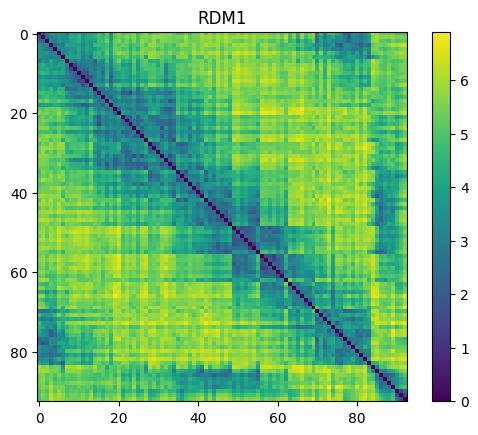

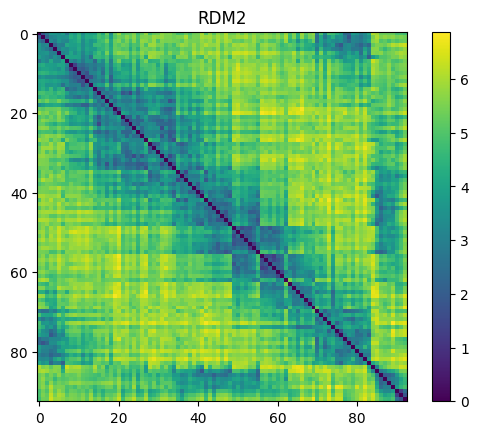

In [12]:
# visualize
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(RDM1)
plt.colorbar()
plt.title("RDM1")
plt.show()

plt.figure()
plt.imshow(RDM2)
plt.colorbar()
plt.title("RDM2")
plt.show()


In [13]:
# compute correlation between the two RDMs
from scipy.stats import spearmanr

corr, pval = spearmanr(RDM1.flatten(), RDM2.flatten())
print("Correlation:", corr, pval)

Correlation: 0.9978617017374803 0.0
